In [1]:

const USE_GPU = true  # Use GPU? If this is set false, then no GPU needs to be available
using Revise
using ParallelStencil
using ParallelStencil.FiniteDifferences3D
using ProgressMeter
using NamedArrays

using Plots, Printf, Statistics



@init_parallel_stencil(CUDA, Float64, 3)
#     @init_parallel_stencil(Threads, Float64, 3)
using GeoPhyInv
plotly()
gr()


┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/backends.jl:435


Plots.GRBackend()

In [2]:
mgrid=fill(range(-500, stop=500, length=255), 3);
medium=Medium(mgrid,[:vp,:rho,:vs])
vpb = [3000., 3500.] # bounds for vp
vsb = [1900, 2000] # bounds for vs
rhob = [1., 2.] # density bounds
GeoPhyInv.update!(medium, [:vp,:vs,:rho], [vpb,vsb,rhob]);
fill!(medium);
# GeoPhyInv.update!(medium, [:vp,:vs,:rho], randn_perc=5); # add some random noise
# medium

medium.bounds[:vs]

2-element Vector{Float64}:
 1900.0
 2000.0

nt:	1935

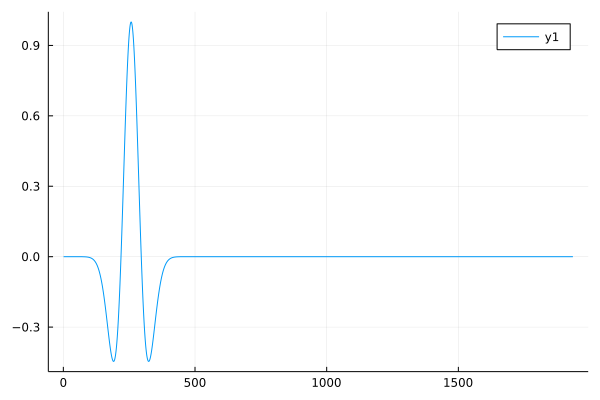

In [3]:
wav, tgrid=ricker(medium, 4, 1, 0.4)

tmax=maximum(tgrid); nt=length(tgrid); 
print("nt:\t",length(tgrid))


freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)


plot(wav)

In [4]:

GeoPhyInv.check_fd_stability(medium.bounds, mgrid, tgrid, freqmin, freqmax, true, 10, 0.5)

┌ Info: spatial sampling (3.94e+00) can be as high as 5.01e+00
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/fdtd.jl:985
┌ Info: time sampling (4.50e-04) can be as high as 4.88e-04
└ @ GeoPhyInv /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/fdtd.jl:1000


In [5]:
pml=GeoPhyInv.pml_variables(251,1e-3,5.,50,2000.,3000.,5.,20.,[true, true]);

In [114]:

@parallel function compute_V!(vx::Data.Array, vy::Data.Array, vz::Data.Array, tauxx::Data.Array, tauyy::Data.Array, tauzz::Data.Array, tauxy::Data.Array, tauxz::Data.Array, tauyz::Data.Array, 
    dtauxx_dx, dtauxy_dx, dtauxz_dx, dtauyy_dy, dtauxy_dy, dtauyz_dy, dtauzz_dz, dtauyz_dz, dtauxz_dz,
    dt::Data.Number, rho, dx::Data.Number, dy::Data.Number, dz::Data.Number)


    @all(dtauxx_dx) = @d_xi(tauxx) / dx
    @all(dtauxy_dx) = @d_xa(tauxy) / dx
    @all(dtauxz_dx) = @d_xa(tauxz) / dx


    @all(dtauyy_dy) = @d_yi(tauyy) / dy
    @all(dtauxy_dy) = @d_ya(tauxy) / dy
    @all(dtauyz_dy) = @d_ya(tauyz) / dy


    @all(dtauzz_dz) = @d_zi(tauzz) / dz
    @all(dtauxz_dz) = @d_za(tauxz) / dz
    @all(dtauyz_dz) = @d_za(tauyz) / dz


    @inn(vx) = @inn(vx) - dt / @av_xi(rho) * (@all(dtauxx_dx) + @all(dtauxy_dy) + @all(dtauxz_dz))
    @inn(vy) = @inn(vy) - dt / @av_yi(rho) * (@all(dtauxy_dx) + @all(dtauyy_dy) + @all(dtauyz_dz))
    @inn(vz) = @inn(vz) - dt / @av_zi(rho) * (@all(dtauxz_dx) + @all(dtauyz_dy) + @all(dtauzz_dz))

    return
end

@parallel function compute_tauii!(tauxx::Data.Array, tauyy::Data.Array, tauzz::Data.Array, vx::Data.Array, vy::Data.Array, vz::Data.Array, 
    dvx_dx::Data.Array, dvy_dy::Data.Array, dvz_dz::Data.Array,
    dt::Data.Number, lambda2mu::Data.Array, lambda::Data.Array, dx::Data.Number, dy::Data.Number, dz::Data.Number)
    @all(dvx_dx) = @d_xa(vx) / dx
    @all(dvy_dy) = @d_ya(vy) / dy
    @all(dvz_dz) = @d_za(vz) / dz

    @all(tauxx) = @all(tauxx) - dt * ((@all(lambda2mu)*(@all(dvx_dx)))  + (@all(lambda)*(@all(dvy_dy) + @all(dvz_dz))))
    @all(tauyy) = @all(tauyy) - dt * ((@all(lambda2mu)*@all(dvy_dy))  + (@all(lambda)*(@all(dvx_dx) + @all(dvz_dz))))
    @all(tauzz) = @all(tauzz) - dt * ((@all(lambda2mu)*@all(dvz_dz))  + (@all(lambda)*(@all(dvy_dy) + @all(dvx_dx))))
    return
end
@parallel function compute_tauij!(tauxy::Data.Array, tauxz::Data.Array, tauyz::Data.Array, vx::Data.Array, vy::Data.Array, vz::Data.Array, 
    dvx_dy,dvx_dz,dvy_dx,dvy_dz,dvz_dx,dvz_dy,
    dt::Data.Number, mu::Data.Array, dx::Data.Number, dy::Data.Number, dz::Data.Number)
    @all(dvx_dy) = @d_yi(vx) / dy
    @all(dvx_dz) = @d_zi(vx) / dz

    @all(dvy_dz) = @d_zi(vy) / dz
    @all(dvy_dx) = @d_xi(vy) / dx

    @all(dvz_dx) = @d_xi(vz) / dx
    @all(dvz_dy) = @d_yi(vz) / dy

    @all(tauxz) = @all(tauxz) - dt * (@av_xzi(mu) * (@all(dvx_dz) + @all(dvz_dx)))
    @all(tauxy) = @all(tauxy) - dt * (@av_xyi(mu) * (@all(dvx_dy) + @all(dvy_dx)))
    @all(tauyz) = @all(tauyz) - dt * (@av_yzi(mu) * (@all(dvy_dz) + @all(dvz_dy)))

    return
end

compute_tauij! (generic function with 1 method)

In [115]:
nz,ny,nx=length.(mgrid)
# Physics
lx, ly, lz = 1000.0, 1000.0, 1000.0  # domain extends
lambda = @zeros(nx, ny, nz)               # lame parameter
lambda2mu = @zeros(nx, ny, nz)               # lame parameter
mu = @zeros(nx, ny, nz)
rho = @zeros(nx,ny,nz)

# mu = medium[:mu]          # mu parameter
copyto!(mu, medium[:mu])
copyto!(rho, medium[:rho])
copyto!(lambda,medium[:lambda])
copyto!(lambda2mu,medium[:M]) # P-wave modulus M

nout = div(length(tgrid),100)            # plotting frequency,10


# fields=[:tauxx,:tauyy,:tauzz,:tauxy,:tauxz,:tauyz,:vx,:vz,:vy]
# w2=NamedArray([NamedArray([@zeros(nx,ny,nz) for i in fields], (fields,)) for i in 1:5], ([:t, :tp, :tpp, :dx, :dy, :dz],))

# Array allocations
tauxx = @zeros(nx, ny, nz)
tauyy = @zeros(nx, ny, nz)
tauzz = @zeros(nx, ny, nz)
tauxy = @zeros(nx - 1, ny - 1, nz - 2)
tauxz = @zeros(nx - 1, ny - 2, nz - 1)
tauyz = @zeros(nx - 2, ny - 1, nz - 1)

vx = @zeros(nx + 1, ny, nz)
vy = @zeros(nx, ny + 1, nz)
vz = @zeros(nx, ny, nz + 1)


      dvx_dx  =@zeros(nx,ny,nz)
      dvy_dy  =@zeros(nx,ny,nz)
      dvz_dz  =@zeros(nx,ny,nz)


      dvx_dy  =@zeros(nx-1,ny-1,nz-2)
      dvx_dz  =@zeros(nx-1,ny-2,nz-1)
      dvy_dx  =@zeros(nx-1,ny-1,nz-2)
      dvy_dz  =@zeros(nx-2,ny-1,nz-1)
      dvz_dx  =@zeros(nx-1,ny-2,nz-1)
      dvz_dy  =@zeros(nx-2,ny-1,nz-1)

      
dtauxx_dx  =@zeros(nx-1,ny-2,nz-2)
dtauyy_dy  =@zeros(nx-2,ny-1,nz-2)
dtauzz_dz  =@zeros(nx-2,ny-2,nz-1)
dtauxy_dx  =@zeros(nx-2,ny-1,nz-2)
dtauxy_dy  =@zeros(nx-1,ny-2,nz-2)
dtauxz_dx  =@zeros(nx-2,ny-2,nz-1)
dtauxz_dz  =@zeros(nx-1,ny-2,nz-2)
dtauyz_dy  =@zeros(nx-2,ny-2,nz-1)
dtauyz_dz  =@zeros(nx-2,ny-1,nz-2)



      memory_dvx_dx  =@zeros(nx,ny,nz)
      memory_dvx_dy  =@zeros(nx,ny,nz)
      memory_dvx_dz  =@zeros(nx,ny,nz)
      memory_dvy_dx  =@zeros(nx,ny,nz)
      memory_dvy_dy  =@zeros(nx,ny,nz)
      memory_dvy_dz  =@zeros(nx,ny,nz)
      memory_dvz_dx  =@zeros(nx,ny,nz)
      memory_dvz_dy  =@zeros(nx,ny,nz)
      memory_dvz_dz  =@zeros(nx,ny,nz)
memory_dtauxx_dx  =@zeros(nx,ny,nz)
memory_dtauyy_dy  =@zeros(nx,ny,nz)
memory_dtauzz_dz  =@zeros(nx,ny,nz)
memory_dtauxy_dx  =@zeros(nx,ny,nz)
memory_dtauxy_dy  =@zeros(nx,ny,nz)
memory_dtauxz_dx  =@zeros(nx,ny,nz)
memory_dtauxz_dz  =@zeros(nx,ny,nz)
memory_dtauyz_dy  =@zeros(nx,ny,nz)
memory_dtauyz_dz  =@zeros(nx,ny,nz)

# memory_dvx_dx


# Initial conditions
# tauxx         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
# tauyy         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])
# tauzz         .= Data.Array([exp(-((ix-1)*dx-0.5*lx)^2 -((iy-1)*dy-0.5*ly)^2 -((iz-1)*dz-0.5*lz)^2) for ix=1:size(tauxx,1), iy=1:size(tauxx,2), iz=1:size(tauxx,3)])



255×255×255 CUDA.CuArray{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0

Animation directory: ./viz3D_out/


Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Total steps=1935, time=2.808e+01 sec (@ T_eff = 73.00 GB/s) 


┌ Info: Saved animation to 
│   fn = /home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif
└ @ Plots /home/pawan/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/pawan/.julia/dev/GeoPhyInv/src/fdtd/acoustic3D.gif")
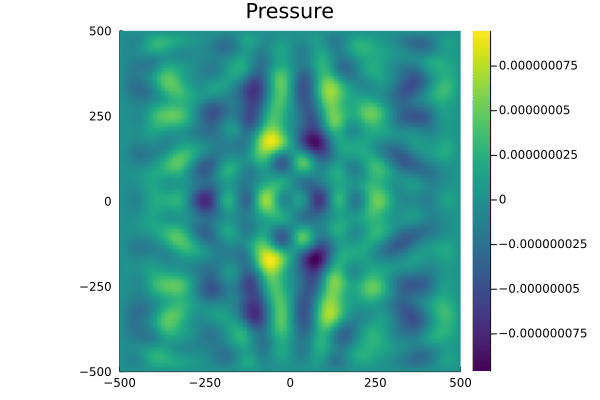

In [117]:
ENV["GKSwstype"] = "nul"; if (isdir("viz3D_out") == false) mkdir("viz3D_out") else foreach(rm, filter(endswith(".png"), readdir("./viz3D_out",join=true))) end; loadpath = "./viz3D_out/"; anim = Animation(loadpath, String[])

	println("Animation directory: $(anim.dir)")
	# Time loop
	@showprogress for it =1:1000
	    if (it == 11)  global wtime0 = Base.time()  end
	   
	    @parallel compute_tauii!(tauxx, tauyy, tauzz, vx, vy, vz, dvx_dx, dvy_dy, dvz_dz, step(tgrid), lambda2mu, lambda, reverse(step.(mgrid))...)
	    tauxx[div(nx, 2),div(ny, 2),div(nz, 2)] += wav[it]
	    @parallel compute_tauij!(tauxy, tauxz, tauyz, vx, vy, vz,   dvx_dy,dvx_dz,dvy_dx,dvy_dz,dvz_dx,dvz_dy,
	    step(tgrid), mu, reverse(step.(mgrid))...)
	    @parallel compute_V!(vx, vy, vz, tauxx, tauyy, tauzz, tauxy, tauxz, tauyz, dtauxx_dx, dtauxy_dx, dtauxz_dx, dtauyy_dy, dtauxy_dy, dtauyz_dy, dtauzz_dz, dtauyz_dz, dtauxz_dz, step(tgrid), rho, reverse(step.(mgrid))...)
	    # t = t + step(tgrid)
	    # Visualisation
	    if mod(it, nout) == 0
		heatmap(mgrid[3], mgrid[1], Array(vx)[1:end - 1,div(ny,2),:]', aspect_ratio=1, xlims=(mgrid[3][1], mgrid[3][end]), ylims=(mgrid[1][1], mgrid[1][end]), c=:viridis, title="Pressure"); frame(anim)
	    end
	end
	# Performance
	wtime    = Base.time() - wtime0
	A_eff    = (4 * 2) / 1e9 * nx * ny * nz * sizeof(Data.Number)  # Effective main memory access per iteration [GB] (Lower bound of required memory access: H and dHdτ have to be read and written (dHdτ for damping): 4 whole-array memaccess; B has to be read: 1 whole-array memaccess)
	wtime_it = wtime / (nt - 10)                           # Execution time per iteration [s]
	T_eff    = A_eff / wtime_it                          # Effective memory throughput [GB/s]
	@printf("Total steps=%d, time=%1.3e sec (@ T_eff = %1.2f GB/s) \n", nt, wtime, round(T_eff, sigdigits=2))
	gif(anim, "acoustic3D.gif", fps=15)
	# return
    # end
    
    
    # acoustic3D()
    

